### Text Sentiment Analysis

#### This is version five

This sentiment analysis model uses deep learning to predict the sentiment of airline-related tweets as negative, neutral, or positive. It consists of three scripts:

Data Preprocessing: The first script reads the raw Kaggle Airline Twitter dataset, cleans the text data by removing mentions, URLs, special characters, numbers, and stopwords. It also tokenizes and lemmatizes the text to generate the cleaned_text column. The preprocessed dataset is then saved as a new CSV file.

Deep Learning Model: The second script reads the preprocessed dataset, tokenizes the cleaned text using Keras, and pads the sequences for uniform input length. The target variable (sentiment) is encoded as integers. The data is split into training and testing sets. A deep learning model is built using Keras with an Embedding layer, LSTM layers, and a Dense output layer. The model is trained on the training data and evaluated on the test data. Predictions are saved to a CSV file, and a classification report is printed.

Results Visualization: The third script reads the true labels and predicted labels from the CSV file generated in the previous step. It creates a confusion matrix to visualize the performance of the model and a bar plot comparing the actual vs. predicted sentiment counts for each sentiment class (negative, neutral, positive).

These three scripts work together to create an end-to-end deep learning sentiment analysis model that processes raw text data, trains a model on the preprocessed data, makes predictions, and visualizes the results.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Copy the data to your local drive
!cp /content/drive/MyDrive/archive/archive-3/Tweets.csv /content/

In [12]:
import pandas as pd
from pandas import Series, DataFrame, isnull, notnull
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a function to clean the text
def clean_text(text):
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Convert emoticons to words
    text = re.sub(r':\)', ' smile ', text)
    text = re.sub(r':\(', ' sad ', text)

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a single string
    text = ' '.join(tokens)
    
    return text

"""# Load the Twitter data
data = pd.read_csv("Tweets.csv")

# Apply the clean_text function to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Save preprocessed data to a new file
data.to_csv('preprocessed_tweets.csv', index=False)"""


"""# Load the Twitter data
data = pd.read_csv("Tweets.csv")

# Apply the clean_text function to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Drop any rows with missing values
data.dropna(subset=['cleaned_text'], inplace=True)

# Save preprocessed data to a new file
data.to_csv('preprocessed_tweets.csv', index=False)"""

# Load the Twitter data
data = pd.read_csv("Tweets.csv")

# Apply the clean_text function to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

"""# Drop any rows with missing values
data.dropna(subset=['cleaned_text'], inplace=True)"""

# Convert the 'cleaned_text' column to strings
data['cleaned_text'] = data['cleaned_text'].astype(str)

# Save preprocessed data to a new file
data.to_csv('preprocessed_tweets.csv', index=False)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Load the preprocessed data
data = pd.read_csv("preprocessed_tweets.csv")

# Filter out non-string values
data = data[data['cleaned_text'].apply(lambda x: isinstance(x, str))]

# Prepare the data for deep learning
X = data['cleaned_text'].values
y = data["airline_sentiment"]

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Tokenize the text
tokenizer = Tokenizer(num_words=5000, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Pad the sequences
max_length = max([len(x) for x in X])
X = pad_sequences(X, maxlen=max_length, padding="post")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the deep learning model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

# Make predictions on the test set
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)


# Print the classification report
print("Classification Report for Deep Learning Model:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Create a DataFrame with the true labels and predicted labels
output_df = pd.DataFrame({"true_labels": y_test, "predicted_labels": y_pred})

# Save the DataFrame to a CSV file
output_df.to_csv("deep_learning_predictions.csv", index=False)

Epoch 1/10
330/330 [==============================] - 47s 128ms/step - loss: 0.7492 - accuracy: 0.6842 - val_loss: 0.6236 - val_accuracy: 0.7239
Epoch 2/10
330/330 [==============================] - 41s 126ms/step - loss: 0.5347 - accuracy: 0.7959 - val_loss: 0.5565 - val_accuracy: 0.7735
Epoch 3/10
330/330 [==============================] - 41s 124ms/step - loss: 0.4209 - accuracy: 0.8476 - val_loss: 0.6190 - val_accuracy: 0.7786
Epoch 4/10
330/330 [==============================] - 39s 119ms/step - loss: 0.3482 - accuracy: 0.8795 - val_loss: 0.6217 - val_accuracy: 0.7675
Epoch 5/10
330/330 [==============================] - 41s 124ms/step - loss: 0.3057 - accuracy: 0.8953 - val_loss: 0.6397 - val_accuracy: 0.7547
Epoch 6/10
330/330 [==============================] - 40s 122ms/step - loss: 0.2661 - accuracy: 0.9088 - val_loss: 0.7080 - val_accuracy: 0.7726
Epoch 7/10
330/330 [==============================] - 40s 121ms/step - loss: 0.2281 - accuracy: 0.9233 - val_loss: 0.8736 - val_ac

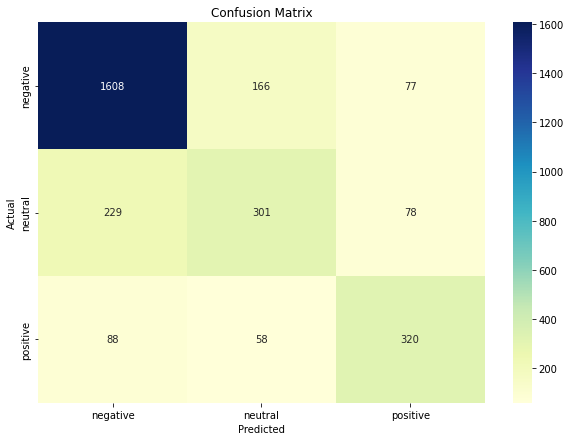

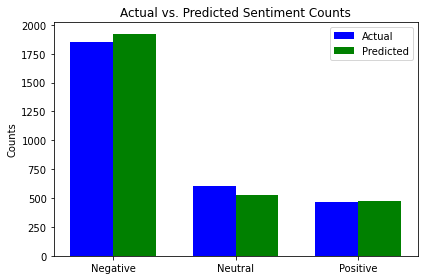

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the predictions data
data = pd.read_csv("deep_learning_predictions.csv")

# Create a confusion matrix
cm = confusion_matrix(data["true_labels"], data["predicted_labels"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Bar plot for actual vs. predicted counts
labels = ['Negative', 'Neutral', 'Positive']
actual_counts = np.bincount(y_test)
predicted_counts = np.bincount(y_pred)

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, actual_counts, width, label='Actual', color='b')
rects2 = ax.bar(x + width / 2, predicted_counts, width, label='Predicted', color='g')

ax.set_ylabel('Counts')
ax.set_title('Actual vs. Predicted Sentiment Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()
